In [1]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from CNN.utility import train_routine
from ds_creation.ds_utility import get_file_count, get_other_class
from ds_creation.split_config import phisical_split
from ds_creation.plot_utility import process_metrics
from prototypical.train.train_setup import train
from prototypical.model.loader import get_samples



SPLIT_PERC = {'train': 0.8, 'val': 0.2}
TEST_SPLIT = 0.2

DATA_DIR = os.path.join('data', 'mammals_calls', 'data')
TEST_DIR = os.path.join('data', 'mammals_calls_test')
SPLIT_DIR = os.path.join('data', 'mammals_calls', 'splits', 'custom')
AUDIO_DIR = os.path.join('data', 'audio')
MODELS_METRICS_DIR = os.path.join("models_metrics")
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")

PATIENCE = 5
TO_TRAIN = True
FROM_START = True
os.makedirs(MODELS_METRICS_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)
    
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Eseguo lo split fisico dei file solo la prima volta per dividere i file in train e test
FIRST_RUN = False
if FIRST_RUN:
    perc = 1-TEST_SPLIT
    phisical_split(DATA_DIR, perc)

2025-10-27 17:45:05.941102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 17:45:06.355221: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-27 17:45:07.878526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Vengono divise le specie in tre gruppi:
* Quelle per il training della CNN, hanno più di 1000 sample, le restanti classi formeranno la classe other
* Quelle per il training della Prototypical, hanno tra i 1000 ed i 100 sample
* Quelle per il test della Prototypical, hanno meno di 100 sample 

Così vengono creati i file che serviranno alla prototypical per splittare le classi tra train, validation e test

In [2]:
count_df = get_file_count(DATA_DIR)

CNN_training = count_df[count_df['file_count'] >= 1000]['species'].tolist()
proto_training = count_df[(count_df['file_count'] <= 1000) & (count_df['file_count'] >= 100)]['species'].tolist()
proto_test = count_df[count_df['file_count'] < 100]['species'].tolist()

random.shuffle(proto_training)
split_idx = int(len(proto_training) * SPLIT_PERC['train'])
proto_train = proto_training[:split_idx]
proto_val = proto_training[split_idx:]
print(len(proto_train), len(proto_val), len(proto_test))
with open(os.path.join(SPLIT_DIR, 'test.txt'), 'w') as f:
    for species in proto_test:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'train.txt'), 'w') as f:
    for species in proto_train:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'val.txt'), 'w') as f:
    for species in proto_val:
        f.write(f"{species}\n")



14 4 21


Viene fisicamente generata la classe other, contenente i files di tutte le altre classi che hanno meno di 1000 sample.
Viene quindi avviato il training della CNN su queste classi con uno split train/val 80/20 per stabilire il numero di epoche ottimale per l'addestramento.

In [3]:
count_df_truncated = get_file_count(DATA_DIR)
count_df_truncated = count_df_truncated[count_df_truncated['file_count'] < 999]

other_species_list = count_df_truncated['species'].tolist()
print(f'Other total files: {count_df_truncated["file_count"].sum()}, species count: {count_df_truncated.shape}, species: {other_species_list}')
get_other_class(DATA_DIR, other_species_list)

count_df = get_file_count(DATA_DIR)

Other total files: 6000, species count: (39, 2), species: ['Common_Dolphin', 'White-sided_Dolphin', 'Walrus', 'Clymene_Dolphin', "Fraser's_Dolphin", 'False_Killer_Whale', 'Striped_Dolphin', 'West_Indian_Manatee', 'Ross_Seal', 'Northern_Right_Whale', "Grampus_Risso's_Dolphin", 'Harbor_Porpoise', 'Minke_Whale', 'Dusky_Dolphin', 'Atlantic_Spotted_Dolphin', 'Long_Beaked_(Pacific)_Common_Dolphin', 'Leopard_Seal', 'Beluga_White_Whale', 'Melon_Headed_Whale', 'White-beaked_Dolphin', 'Gray_Whale', 'Harp_Seal', 'Southern_Right_Whale', 'Boutu_Amazon_River_Dolphin', 'Ribbon_Seal', "Heaviside's_Dolphin", "Dall's_Porpoise", 'Rough-Toothed_Dolphin', 'Spotted_Seal', 'Irawaddy_Dolphin', 'Narwhal', 'Ringed_Seal', 'Juan_Fernandez_Fur_Seal', 'Tucuxi_Dolphin', 'Hooded_Seal', 'Sea_Otter', 'Finless_Porpoise', 'Steller_Sea_Lion', 'New_Zealand_Fur_Seal']


In [4]:
other_ds, history = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), cardinality=1000, subfolder='14-10_training', from_start=FROM_START, to_train=TO_TRAIN)


Total classes found: 13


I0000 00:00:1761587110.660065   47648 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18314 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:18:00.0, compute capability: 8.9


['Sperm_Whale', 'Fin_Finback_Whale', 'other', 'Humpback_Whale', 'Short-Finned_(Pacific)_Pilot_Whale', 'Bowhead_Whale', 'Killer_Whale', 'Bearded_Seal', 'Spinner_Dolphin', 'Long-Finned_Pilot_Whale', 'Pantropical_Spotted_Dolphin', 'Bottlenose_Dolphin', 'Weddell_Seal']
training
Epoch 1/50


2025-10-27 17:45:25.984315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23776 of 56084
2025-10-27 17:45:35.984502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 52494 of 56084
2025-10-27 17:45:37.499032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-10-27 17:45:37.525189: I external/local_xla/xla/service/service.cc:163] XLA service 0x17bd2570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-27 17:45:37.525482: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-10-27 17:45:37.640897: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-27 17

   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:17 22ms/step - accuracy: 0.0784 - loss: 4.2693  

I0000 00:00:1761587142.906736   47857 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 140s 32ms/step - accuracy: 0.7281 - loss: 0.6353 - val_accuracy: 0.8596 - val_loss: 0.3966 - val_confusion_matrix: 83.0118
Epoch 2/50


2025-10-27 17:47:33.262610: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-27 17:47:43.455292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26366 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:07 19ms/step - accuracy: 0.8479 - loss: 0.5192  

2025-10-27 17:47:53.101497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 123s 29ms/step - accuracy: 0.8611 - loss: 0.3105 - val_accuracy: 0.7043 - val_loss: 0.8741 - val_confusion_matrix: 83.0118
Epoch 3/50


2025-10-27 17:49:35.935988: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-27 17:49:46.043704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26498 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:09 20ms/step - accuracy: 0.8520 - loss: 0.2440  

2025-10-27 17:49:55.799573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 120s 29ms/step - accuracy: 0.8864 - loss: 0.2527 - val_accuracy: 0.8438 - val_loss: 0.4040 - val_confusion_matrix: 83.0118
Epoch 4/50


2025-10-27 17:51:46.092906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26621 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:10 20ms/step - accuracy: 0.9224 - loss: 0.2732  

2025-10-27 17:51:55.688876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 28ms/step - accuracy: 0.8984 - loss: 0.2234 - val_accuracy: 0.8907 - val_loss: 0.3185 - val_confusion_matrix: 83.0118
Epoch 5/50


2025-10-27 17:53:35.389974: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-27 17:53:45.456755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26314 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:11 20ms/step - accuracy: 0.8484 - loss: 0.2763  

2025-10-27 17:53:55.094637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 120s 29ms/step - accuracy: 0.9048 - loss: 0.2050 - val_accuracy: 0.8469 - val_loss: 0.4485 - val_confusion_matrix: 83.0118
Epoch 6/50


2025-10-27 17:55:45.404619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26593 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:11 20ms/step - accuracy: 0.8723 - loss: 0.1972  

2025-10-27 17:55:54.956395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 28ms/step - accuracy: 0.9095 - loss: 0.1950 - val_accuracy: 0.9040 - val_loss: 0.2704 - val_confusion_matrix: 83.0118
Epoch 7/50


2025-10-27 17:57:44.687734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26495 of 56084


   4/3506 ━━━━━━━━━━━━━━━━━━━━ 1:08 20ms/step - accuracy: 0.9362 - loss: 0.2011   

2025-10-27 17:57:54.208721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 120s 29ms/step - accuracy: 0.9134 - loss: 0.1851 - val_accuracy: 0.8921 - val_loss: 0.3266 - val_confusion_matrix: 83.0118
Epoch 8/50


2025-10-27 17:59:44.373663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26400 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:10 20ms/step - accuracy: 0.8785 - loss: 0.1507  

2025-10-27 17:59:53.854080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 28ms/step - accuracy: 0.9155 - loss: 0.1793 - val_accuracy: 0.9109 - val_loss: 0.2456 - val_confusion_matrix: 83.0118
Epoch 9/50


2025-10-27 18:01:32.872566: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-27 18:01:42.938957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26557 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:08 19ms/step - accuracy: 0.9053 - loss: 0.1027  

2025-10-27 18:01:52.307941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 29ms/step - accuracy: 0.9181 - loss: 0.1713 - val_accuracy: 0.7144 - val_loss: 0.7488 - val_confusion_matrix: 83.0118
Epoch 10/50


2025-10-27 18:03:42.403102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26141 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:06 19ms/step - accuracy: 0.8603 - loss: 1.1328  

2025-10-27 18:03:51.905795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 28ms/step - accuracy: 0.9195 - loss: 0.1725 - val_accuracy: 0.7958 - val_loss: 0.5871 - val_confusion_matrix: 83.0118
Epoch 11/50


2025-10-27 18:05:41.656537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26712 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:10 20ms/step - accuracy: 0.9088 - loss: 0.1472  

2025-10-27 18:05:51.086977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 117s 28ms/step - accuracy: 0.9185 - loss: 0.1725 - val_accuracy: 0.9115 - val_loss: 0.2444 - val_confusion_matrix: 83.0118
Epoch 12/50


2025-10-27 18:07:38.253480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26553 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:07 19ms/step - accuracy: 0.9033 - loss: 0.1912  

2025-10-27 18:07:47.788344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 28ms/step - accuracy: 0.9204 - loss: 0.1660 - val_accuracy: 0.7333 - val_loss: 0.7104 - val_confusion_matrix: 83.0118
Epoch 13/50


2025-10-27 18:09:37.510095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26480 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:06 19ms/step - accuracy: 0.9171 - loss: 0.1317  

2025-10-27 18:09:47.018278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 120s 29ms/step - accuracy: 0.9212 - loss: 0.1658 - val_accuracy: 0.9192 - val_loss: 0.2205 - val_confusion_matrix: 83.0118
Epoch 14/50


2025-10-27 18:11:37.454298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26566 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:07 19ms/step - accuracy: 0.9345 - loss: 0.1826  

2025-10-27 18:11:46.908309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 29ms/step - accuracy: 0.9223 - loss: 0.1592 - val_accuracy: 0.9157 - val_loss: 0.2400 - val_confusion_matrix: 83.0118
Epoch 15/50


2025-10-27 18:13:36.856252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26490 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:06 19ms/step - accuracy: 0.9405 - loss: 0.1285  

2025-10-27 18:13:46.396847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 120s 29ms/step - accuracy: 0.9228 - loss: 0.1576 - val_accuracy: 0.8944 - val_loss: 0.2983 - val_confusion_matrix: 83.0118
Epoch 16/50


2025-10-27 18:15:37.199066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26498 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:11 21ms/step - accuracy: 0.9689 - loss: 0.0589  

2025-10-27 18:15:46.703042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 119s 28ms/step - accuracy: 0.9234 - loss: 0.1570 - val_accuracy: 0.8921 - val_loss: 0.3321 - val_confusion_matrix: 83.0118
Epoch 17/50


2025-10-27 18:17:26.343186: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-27 18:17:36.416550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26467 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:09 20ms/step - accuracy: 0.9308 - loss: 0.2284  

2025-10-27 18:17:45.862429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 120s 29ms/step - accuracy: 0.9254 - loss: 0.1551 - val_accuracy: 0.9074 - val_loss: 0.2401 - val_confusion_matrix: 83.0118
Epoch 18/50


2025-10-27 18:19:36.088597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26480 of 56084


   7/3506 ━━━━━━━━━━━━━━━━━━━━ 1:11 20ms/step - accuracy: 0.9794 - loss: 0.0762  

2025-10-27 18:19:45.576237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 121s 29ms/step - accuracy: 0.9255 - loss: 0.1527 - val_accuracy: 0.9140 - val_loss: 0.2650 - val_confusion_matrix: 83.0118
{'accuracy': [0.7280864715576172, 0.8611012101173401, 0.8864025473594666, 0.898438036441803, 0.9048391580581665, 0.9095463752746582, 0.9134334325790405, 0.9154838919639587, 0.9180871844291687, 0.9194779396057129, 0.9184794425964355, 0.9203516244888306, 0.9211539626121521, 0.9222772717475891, 0.9227944016456604, 0.9234006404876709, 0.9254154562950134, 0.925468921661377], 'loss': [0.6353477835655212, 0.31053295731544495, 0.25274813175201416, 0.2233933061361313, 0.20495954155921936, 0.194968119263649, 0.18505950272083282, 0.17932462692260742, 0.17128363251686096, 0.17250722646713257, 0.17253035306930542, 0.1660401076078415, 0.16575761139392853, 0.15919898450374603, 0.15755638480186462, 0.15700790286064148, 0.15510958433151245, 0.15269997715950012], 'val_accuracy': [0.8596478700637817, 0.7043267488479614, 0.8437522053718567, 0.89072632789

In [5]:
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print(f'Best epoch: {best_epoch}, val_accuracy: {history.history["val_accuracy"][best_epoch-1]}, accuracy: {history.history["accuracy"][best_epoch-1]}')

Best epoch: 13, val_accuracy: 0.9192387461662292, accuracy: 0.9211539626121521


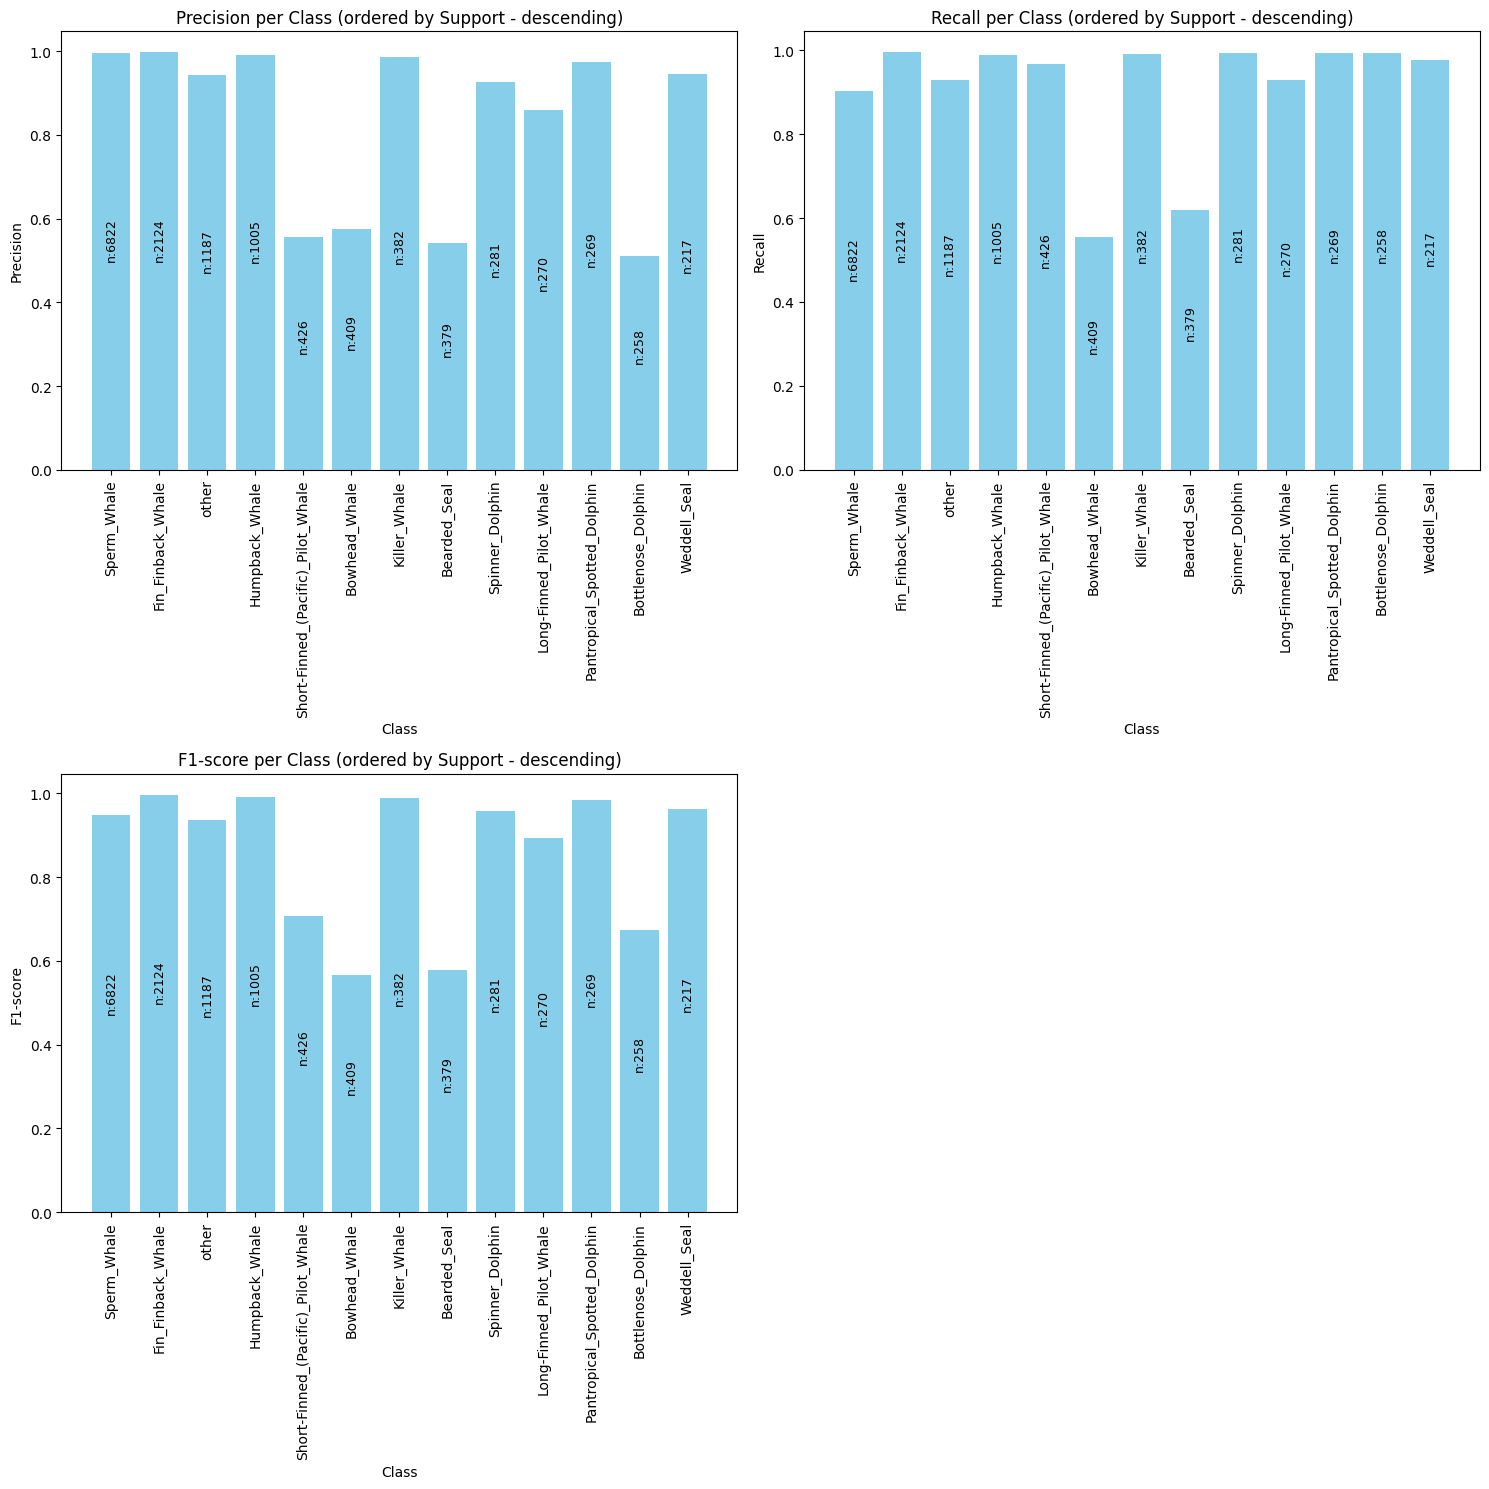

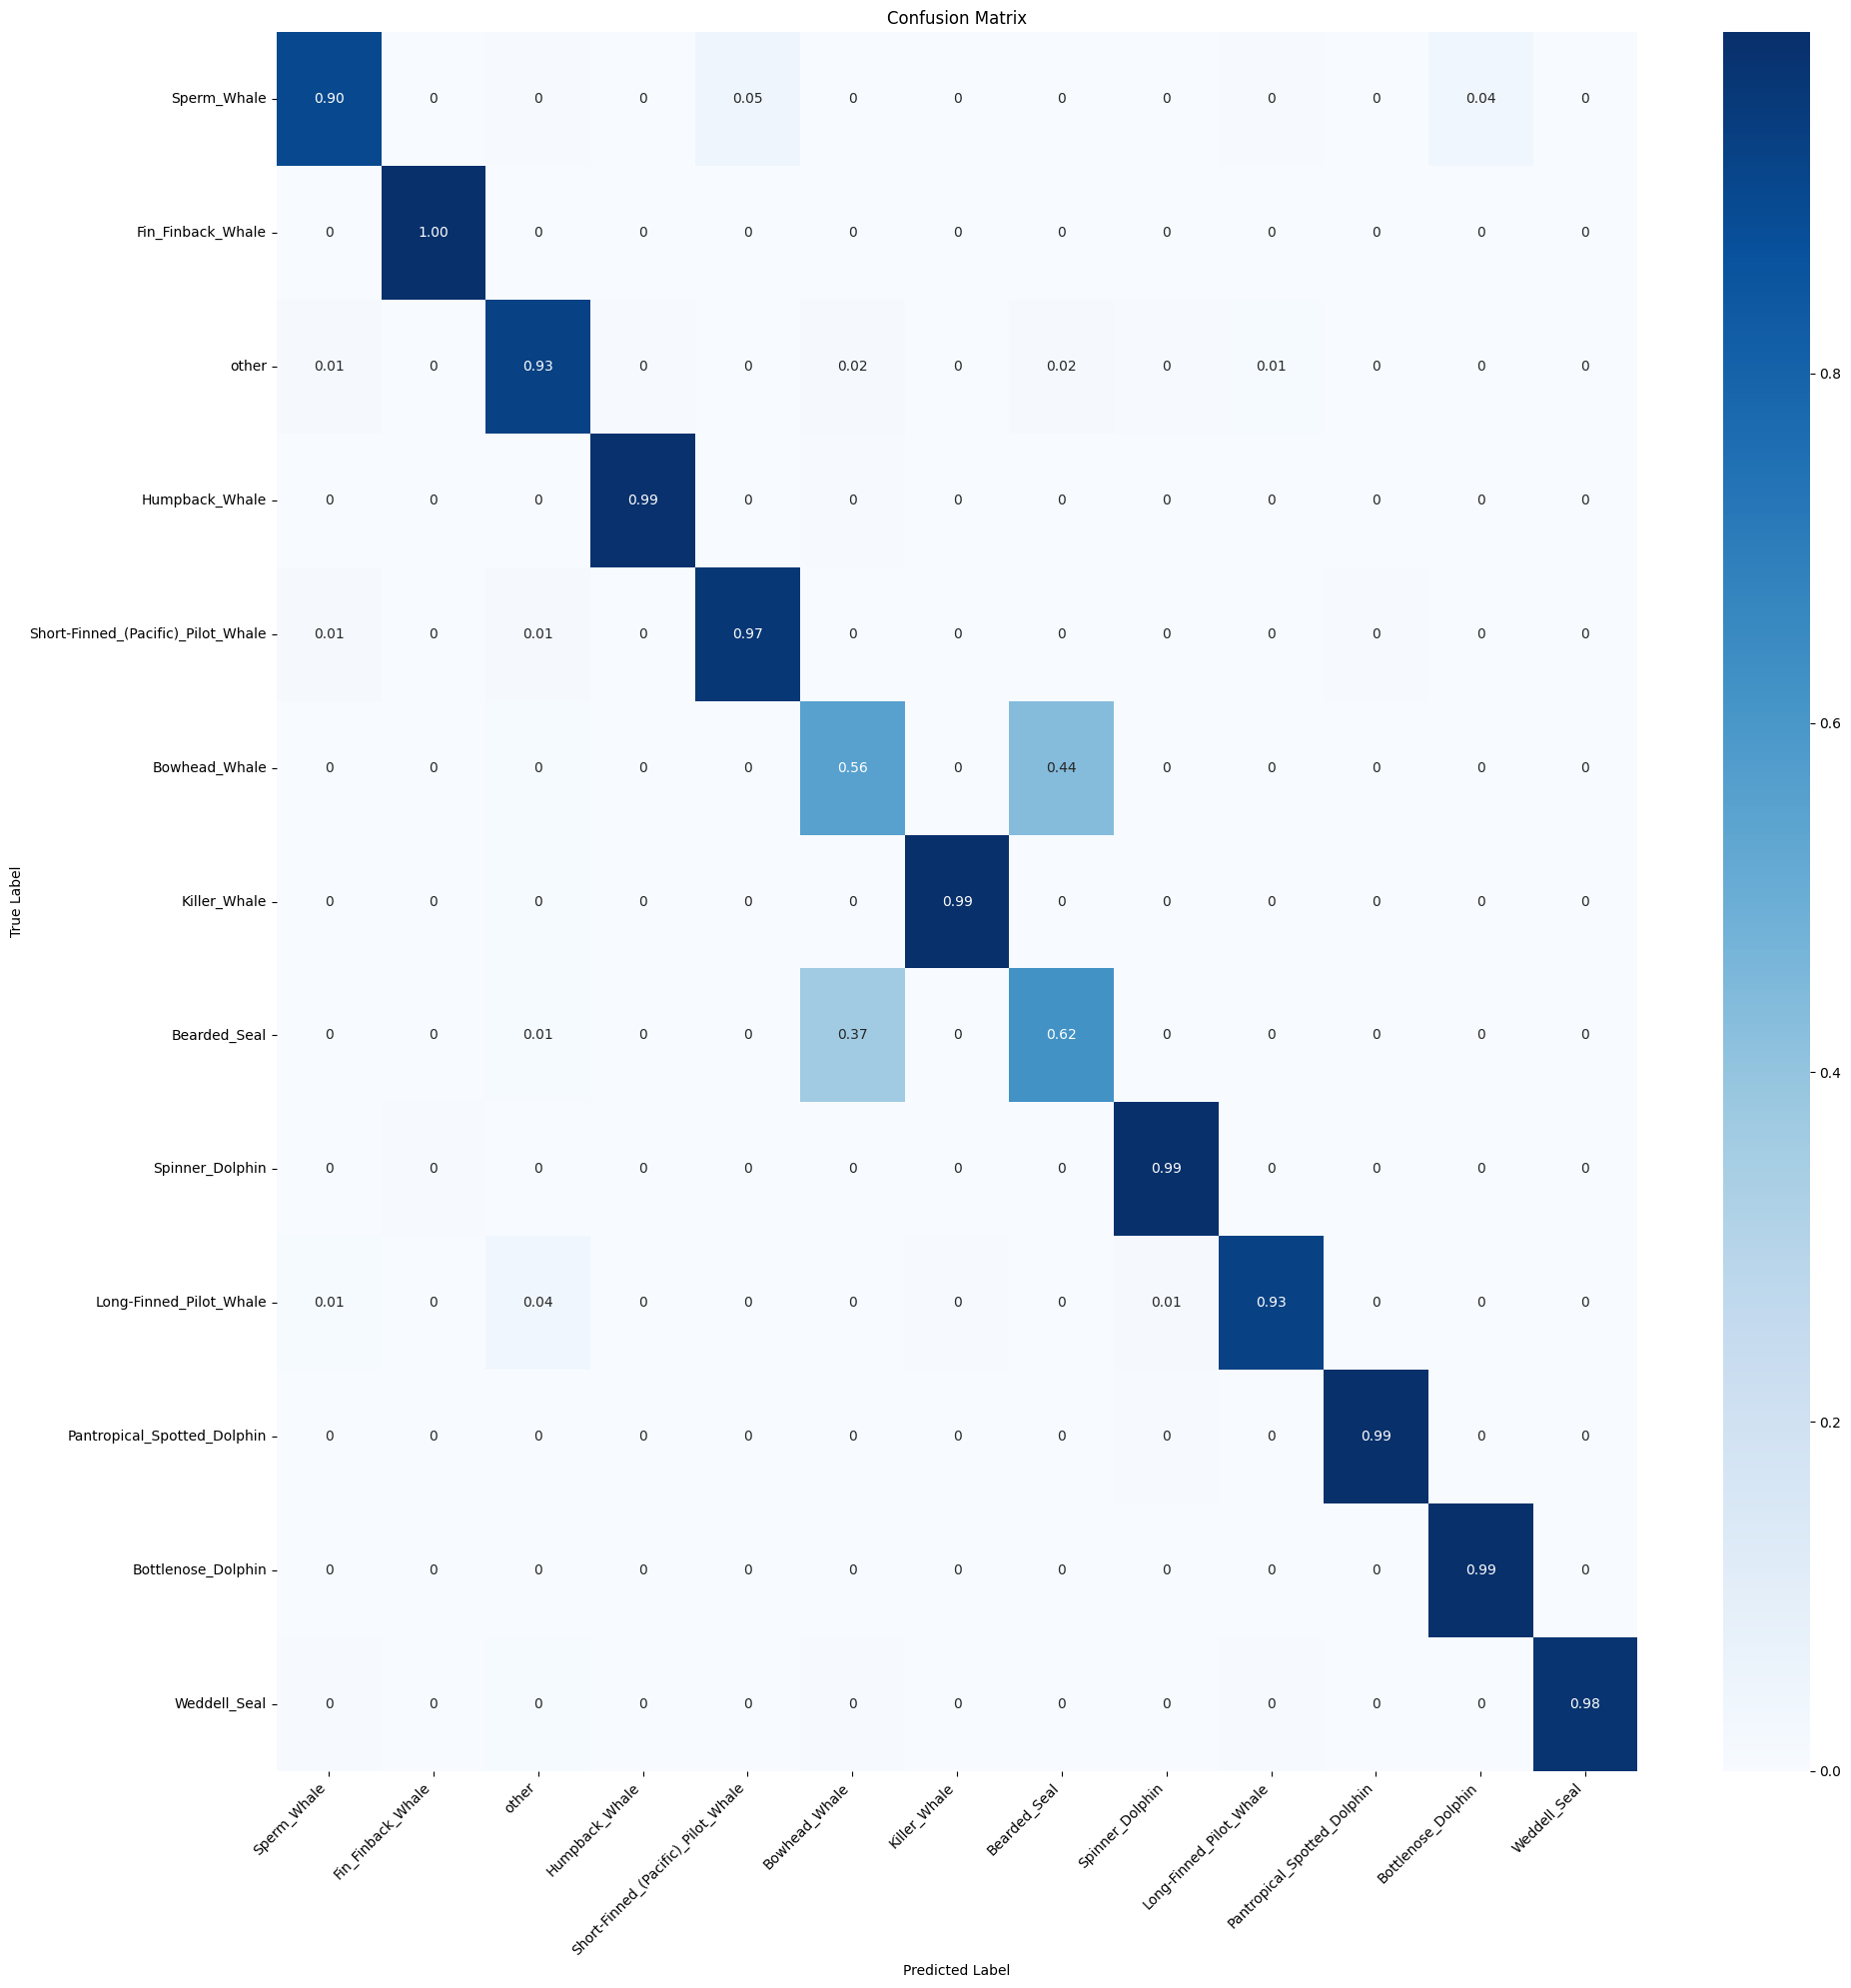

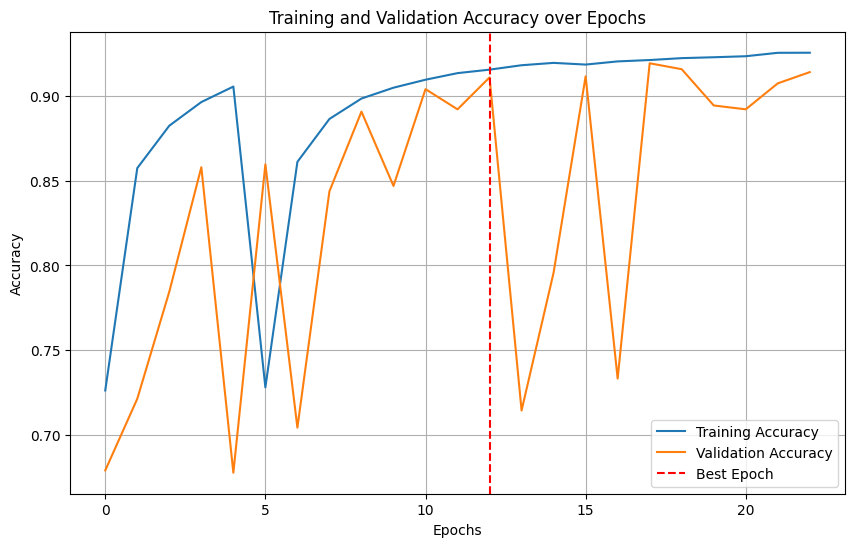

In [6]:
curr_training_date = '14-10'
process_metrics(count_df, 13, os.path.join(MODELS_METRICS_DIR, f'{curr_training_date}_training'), MODELS_METRICS_DIR)

## Proto Training

In [7]:
config = {
    "data.dataset": "mammals_calls",
    "data.split": "custom",
    "data.train_way": 4,
    "data.train_support": 2,
    "data.train_query": 3,
    "data.test_way": 4,
    "data.test_support": 2,
    "data.test_query": 3,
    "data.episodes": 10,
    "data.gpu": 0,
    "data.cuda":True,
    "model.x_dim": "164,397,3",
    "model.z_dim": 64,
    "train.epochs": 50,
    'train.optim_method': "Adam",
    "train.lr": 0.001,
    "train.patience": 5,
    "model.save_path": 'data_cache/proto/test_mammals_calls.keras'
}

train(config)

Loaded 2 splits with 4 classes each.
Training started.
Epoch 1 started.
support shape: (4, 2, 164, 397, 3), query shape: (4, 3, 164, 397, 3)
support shape: (4, 2, 164, 397, 3), query shape: (4, 3, 164, 397, 3)
support shape: (4, 2, 164, 397, 3), query shape: (4, 3, 164, 397, 3)
Epoch 1 ended.
Epoch 2, Loss: 4.713308811187744, Accuracy: 0.5833333730697632, Val Loss: 1.7541579008102417, Val Accuracy: 0.5481482148170471
Saving new best model with accuracy: 0.5481482
Epoch 2 started.
Epoch 2 ended.
Epoch 3, Loss: 1.071641206741333, Accuracy: 0.6083332896232605, Val Loss: 1.0590137243270874, Val Accuracy: 0.6555556058883667
Saving new best model with accuracy: 0.6555556
Epoch 3 started.
Epoch 3 ended.
Epoch 4, Loss: 0.8182646036148071, Accuracy: 0.7166666388511658, Val Loss: 1.0255622863769531, Val Accuracy: 0.6194444894790649
Epoch 4 started.
Epoch 4 ended.
Epoch 5, Loss: 0.9673578143119812, Accuracy: 0.6583333015441895, Val Loss: 1.3285928964614868, Val Accuracy: 0.5564813613891602
Epoch 

In [8]:
classes = proto_val + proto_train + proto_test
n_support_dict = {curr_class: len(os.listdir(os.path.join(DATA_DIR, curr_class))) for curr_class in classes}
results = get_samples(classes, n_support_dict, (w, h, 3), os.path.join('data_cache', 'proto', 'test_mammals_calls.keras'), DATA_DIR)

TypeError: tuple indices must be integers or slices, not str